In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-multilearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score
from skmultilearn.model_selection import iterative_train_test_split

#### Reading File

In [5]:
df = pd.read_csv("../data/cleaned_data.csv")

In [6]:
df.head()

,Complaint Id,Tax ID,Officer Days On Force At Incident,Allegation Record Identity,Incident Hour,Precinct Of Incident Occurrence,Total Complaints,Total Substantiated Complaints,year,in_news,...,Officer Gender_TGNC / Other,Current Rank_Captain,Current Rank_Chiefs and other ranks,Current Rank_Deputy Inspector,Current Rank_Detective,Current Rank_Inspector,Current Rank_Lieutenant,Current Rank_Police Officer,Current Rank_Sergeant,CCRB Complaint Disposition
0,201903940.0,931819.0,6133.0,1069408.0,7.0,63.0,19.0,1.0,2019.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Unsubstantiated
1,201408395.0,915305.0,6989.0,902975.0,5.0,73.0,2.0,1.0,2014.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Substantiated
2,201408395.0,915305.0,6989.0,902874.0,5.0,73.0,2.0,1.0,2014.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Substantiated
3,201902150.0,962844.0,860.0,1064585.0,2.0,42.0,2.0,0.0,2019.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Exonerated
4,201902150.0,962844.0,860.0,1064589.0,2.0,42.0,2.0,0.0,2019.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Exonerated


#### Setting up X and Y, Splitting Datasets, and SMOTE

In [7]:
#setting up y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["CCRB Complaint Disposition"])

In [8]:
# View the class-to-integer mapping
print("Class to Integer Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Class to Integer Mapping: {'Exonerated': 0, 'Substantiated': 1, 'Unfounded': 2, 'Unsubstantiated': 3}


In [9]:
#setting up x
x = df.drop(columns = ["CCRB Complaint Disposition"])

In [10]:
#training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train, random_state = 3)

In [11]:
#SMOTE for class imbalance
smote = SMOTE(random_state = 10)

In [12]:
#applying SMOTE to training
x_res, y_res = smote.fit_resample(x_train, y_train)

In [13]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

3    3196
1    2381
0     634
2     394
Name: count, dtype: int64
0    3196
1    3196
3    3196
2    3196
Name: count, dtype: int64


#### Initial Models

In [14]:
def model_perf(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()



              precision    recall  f1-score   support

           0       0.13      0.60      0.22       159
           1       0.23      0.01      0.03       595
           2       0.08      0.04      0.05        99
           3       0.53      0.57      0.55       799

    accuracy                           0.34      1652
   macro avg       0.24      0.30      0.21      1652
weighted avg       0.36      0.34      0.30      1652

Balanced Accuracy: 0.30426020730056436
F1-Weighted: 0.2982469221231701
F1-Macro: 0.2110561611246543


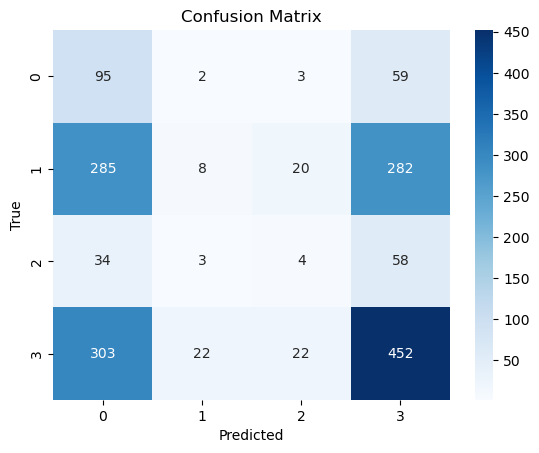

In [15]:
#logistic regression
model_perf("Logistic", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.89      0.48      0.62       159
           1       0.94      0.90      0.92       595
           2       0.86      0.67      0.75        99
           3       0.83      0.96      0.89       799

    accuracy                           0.87      1652
   macro avg       0.88      0.75      0.80      1652
weighted avg       0.88      0.87      0.87      1652

Balanced Accuracy: 0.7501005861999557
F1-Weighted: 0.8662389942729575
F1-Macro: 0.7954268800520435


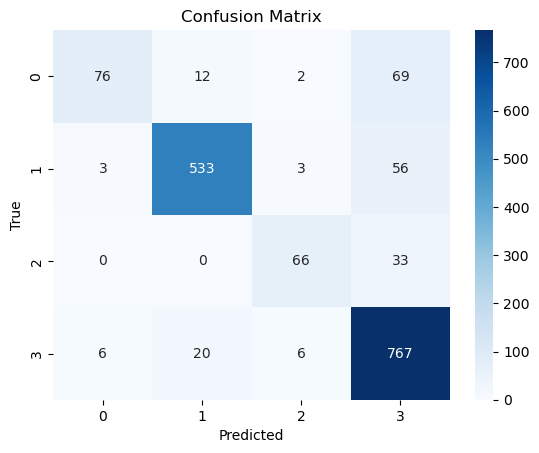

In [16]:
#random forest
model_perf("RF", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.13      0.59      0.21       159
           1       0.00      0.00      0.00       595
           2       0.00      0.00      0.00        99
           3       0.53      0.62      0.57       799

    accuracy                           0.35      1652
   macro avg       0.17      0.30      0.20      1652
weighted avg       0.27      0.35      0.30      1652

Balanced Accuracy: 0.30174117017340857
F1-Weighted: 0.2960667919811379
F1-Macro: 0.1956711767865117


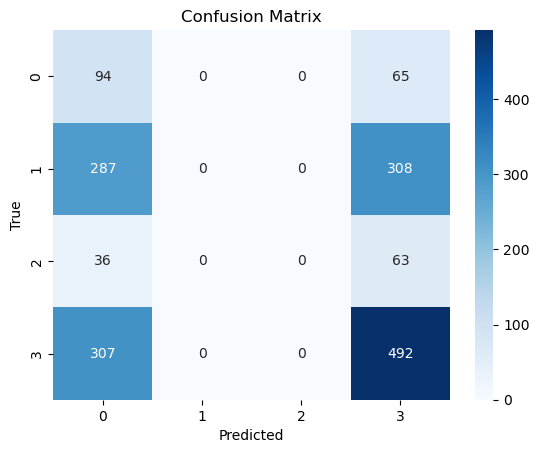

In [17]:
#svm
model_perf("SVM", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.78      0.48      0.59       159
           1       0.97      0.88      0.92       595
           2       0.87      0.75      0.80        99
           3       0.82      0.95      0.88       799

    accuracy                           0.87      1652
   macro avg       0.86      0.77      0.80      1652
weighted avg       0.87      0.87      0.86      1652

Balanced Accuracy: 0.7652695293413644
F1-Weighted: 0.8646722842124727
F1-Macro: 0.80033476999234


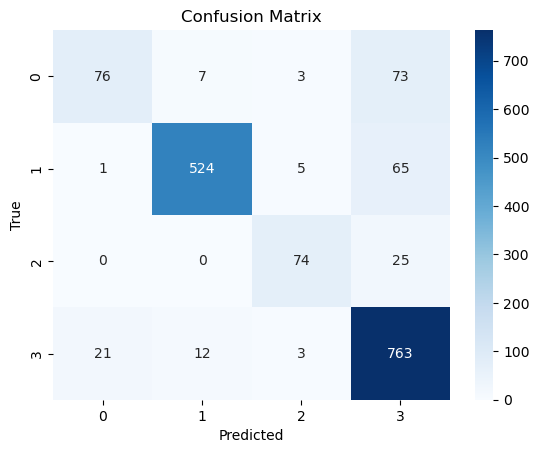

In [18]:
#XGBoost
model_perf("XGB", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.23      0.52      0.31       159
           1       0.61      0.55      0.58       595
           2       0.24      0.59      0.35        99
           3       0.71      0.45      0.55       799

    accuracy                           0.50      1652
   macro avg       0.45      0.53      0.45      1652
weighted avg       0.60      0.50      0.53      1652

Balanced Accuracy: 0.5270046183747272
F1-Weighted: 0.526806527416547
F1-Macro: 0.4478200256938513


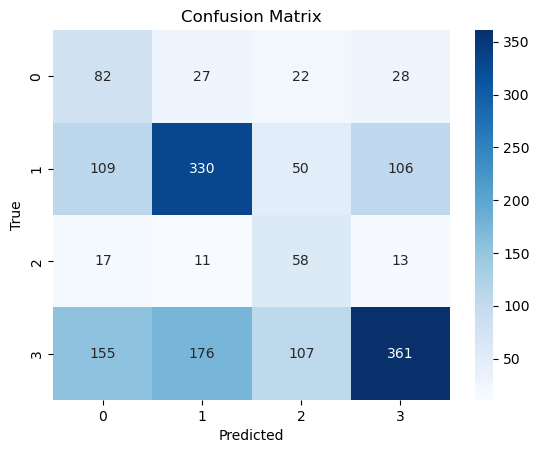

In [19]:
#KNN
model_perf("KNN", x_res, y_res, x_valid, y_valid)

#### Hyperparameter Tuning

In [20]:
#parameter to tune for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [21]:
#initiates rf
rf_tune = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")

In [22]:
#randomized search + cross validation
rf_gs = RandomizedSearchCV(rf_tune, rf_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)

In [23]:
rf_gs.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300]},
                   random_state=42, scoring='f1_weighted')

In [37]:
#performance and best params
print("Best Parameters:", rf_gs.best_params_)
print("Best F1 Score (Weighted):", rf_gs.best_score_)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Best F1 Score (Weighted): 0.8409400654167409


In [25]:
#parameters to tune for XG Boost
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2] 
}

In [26]:
#initiates xg boost
xgb_tuned = XGBClassifier(objective='multi:softmax', 
                            num_class=4,
                          random_state=2)

In [27]:
#randomized search + cross validation
xgb_sv = RandomizedSearchCV(xgb_tuned, xgb_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)

In [28]:
#fixes columns
x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [29]:
xgb_sv.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_class=4, num_parallel_tree=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='f1_weighted')

In [38]:
#performance and best params
print("Best Parameters:", xgb_sv.best_params_)
print("Best F1 Score (Weighted):", xgb_sv.best_score_)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1 Score (Weighted): 0.8553976203427455


#### Multilabel

In [31]:
#encoding ccrb disposition
df["CCRB Complaint Disposition"] = label_encoder.fit_transform(df["CCRB Complaint Disposition"])

In [32]:
#setting x and  y
y_cols = [col for col in df.columns if "NYPD Officer Penalty" in col]
y_2 = df[y_cols].reset_index(drop = True)
x_2 = df.drop(columns = y_cols).reset_index(drop = True)

In [35]:
def model_perf_multi(col:int, x, y):
    """
    Given the target variable via column index,
    Will perform train-test-split, SMOTE, and 
    return model with the best performance
    """
    #set target
    y_temp = y_2.iloc[:,col]
    
    #training, validation, and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y_temp, test_size = 0.2, stratify = y_temp, random_state = 3)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train, random_state = 3)
    
    #smote
    smote = SMOTE(random_state = 10)
    #applying SMOTE to training
    x_res, y_res = smote.fit_resample(x_train, y_train)
    
    #list of models
    mod_types = ["Logistic", "RF", "SVM", "XGB", "KNN"]
    
    #list of scores
    scores = []
    preds = []
    #computes score for each model
    for model in mod_types:
        #determine and initialize mode
        if model == "Logistic":
            mod = LogisticRegression(max_iter = 1000, 
                                 class_weight='balanced',
                                 random_state = 2)
        elif model == "RF":
            mod = RandomForestClassifier(n_estimators = 100, 
                                         class_weight='balanced',
                                         random_state = 2)
        elif model == "SVM":
            mod = SVC(kernel='rbf',
                      class_weight='balanced',
                      random_state=2)
        elif model == "XGB":
            mod = XGBClassifier(objective='binary:logistic', 
                                random_state=2)
            x_res.columns = x_res.columns.str.replace(r'[\[\]<>]', '', regex=True)
            x_valid.columns = x_valid.columns.str.replace(r'[\[\]<>]', '', regex=True)

        elif model == "KNN":
            mod = KNeighborsClassifier(n_neighbors=5)
        
        #fit model
        mod.fit(x_res, y_res)

        #compute predicted
        pred = mod.predict(x_valid)

        #computes performance metrics 
        fl_weighted = f1_score(y_valid, pred, average = 'weighted')
        scores.append(fl_weighted)
        preds.append(pred)
    
    max_i = scores.index(max(scores))
    best_mod = mod_types[max_i]
    conf_matrix = confusion_matrix(y_valid, preds[max_i])
    class_report = classification_report(y_valid, preds[max_i], zero_division = 0)
    
    #printing report
    print(best_mod)
    print(f'F1-Weighted: {max(scores)}')
    print(class_report)
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()



NYPD Officer Penalty_Vacation Loss
RF
F1-Weighted: 0.9950166408212495
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1599
         1.0       0.98      0.87      0.92        53

    accuracy                           1.00      1652
   macro avg       0.99      0.93      0.96      1652
weighted avg       1.00      1.00      1.00      1652



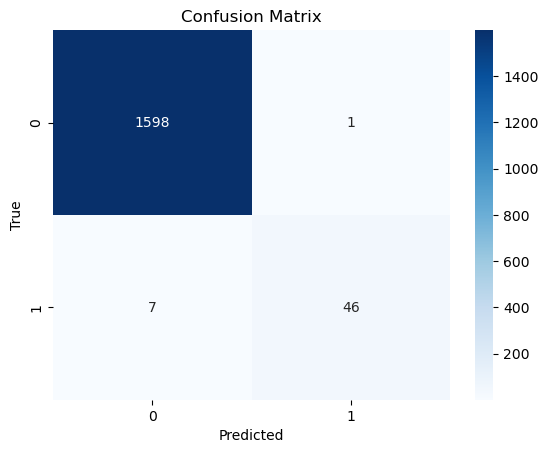

NYPD Officer Penalty_Command Discipline A
XGB
F1-Weighted: 0.9859718384377946
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1563
         1.0       0.97      0.78      0.86        89

    accuracy                           0.99      1652
   macro avg       0.98      0.89      0.93      1652
weighted avg       0.99      0.99      0.99      1652



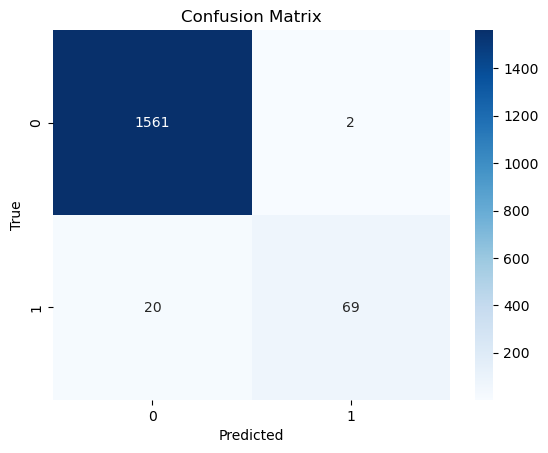

NYPD Officer Penalty_Command Discipline B
XGB
F1-Weighted: 0.9993880401393365
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1629
         1.0       1.00      0.96      0.98        23

    accuracy                           1.00      1652
   macro avg       1.00      0.98      0.99      1652
weighted avg       1.00      1.00      1.00      1652



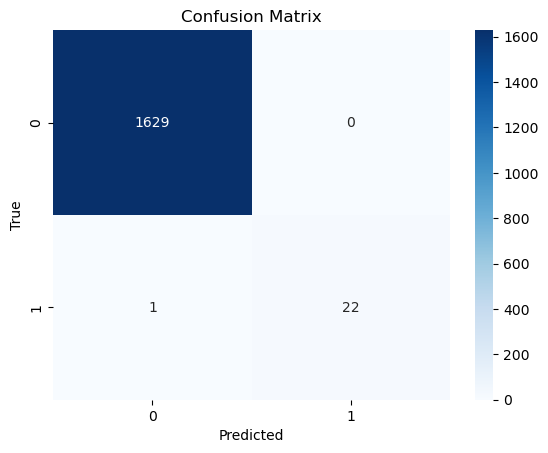

NYPD Officer Penalty_Formalized Training
XGB
F1-Weighted: 0.9844916141625892
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1543
         1.0       0.93      0.83      0.88       109

    accuracy                           0.98      1652
   macro avg       0.96      0.92      0.94      1652
weighted avg       0.98      0.98      0.98      1652



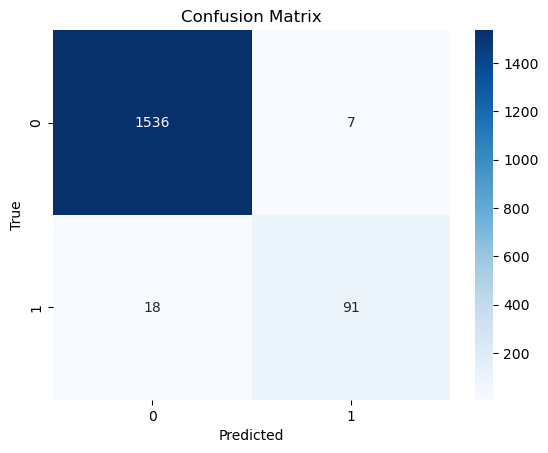

NYPD Officer Penalty_Instructions
RF
F1-Weighted: 0.9820319466385551
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1579
         1.0       0.98      0.64      0.78        73

    accuracy                           0.98      1652
   macro avg       0.98      0.82      0.88      1652
weighted avg       0.98      0.98      0.98      1652



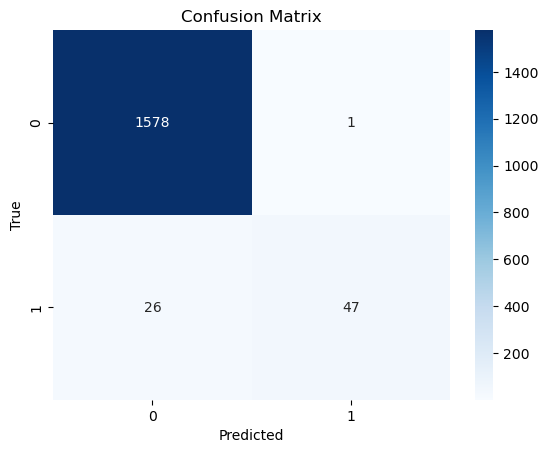

NYPD Officer Penalty_None
XGB
F1-Weighted: 0.9939952739889926
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1593
         1.0       0.90      0.93      0.92        59

    accuracy                           0.99      1652
   macro avg       0.95      0.96      0.96      1652
weighted avg       0.99      0.99      0.99      1652



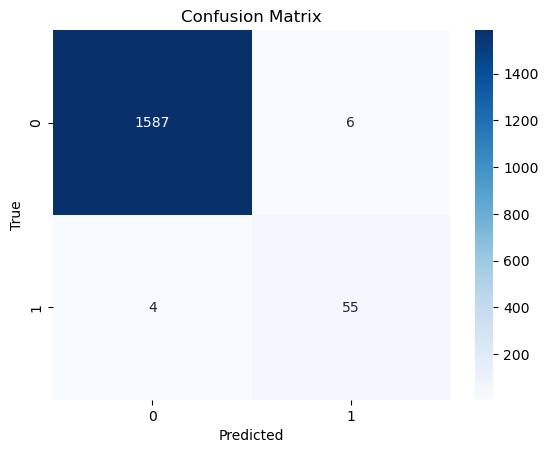

NYPD Officer Penalty_Left
XGB
F1-Weighted: 0.9993745875838728
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1644
         1.0       1.00      0.88      0.93         8

    accuracy                           1.00      1652
   macro avg       1.00      0.94      0.97      1652
weighted avg       1.00      1.00      1.00      1652



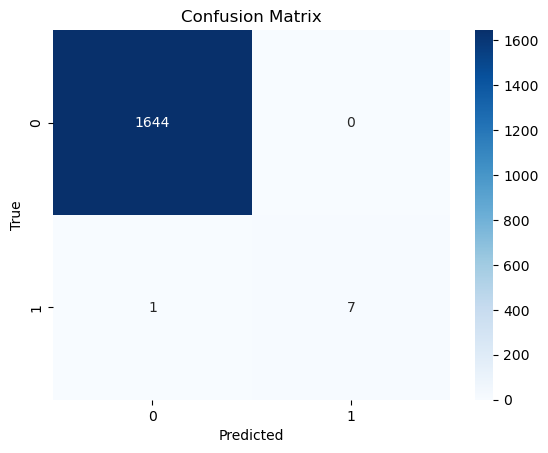

NYPD Officer Penalty_Other
RF
F1-Weighted: 0.9992938769991434
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1650
         1.0       1.00      0.50      0.67         2

    accuracy                           1.00      1652
   macro avg       1.00      0.75      0.83      1652
weighted avg       1.00      1.00      1.00      1652



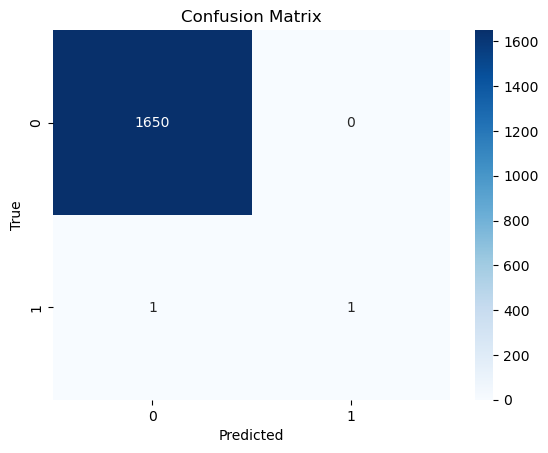

In [36]:
for col in range(y_2.shape[1]):
    print(y_2.columns[col])
    model_perf_multi(col, x_2, y_2)